# Algorithm to measure the radius and diameter of the Human Iris

### Importing libraries

In [75]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from scipy.spatial import distance
import statistics
%matplotlib inline

### Display image for reference

In [76]:
def display_img(img,name):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap ="gray")
    plt.title(name)

### Global set path

In [101]:
path = glob.glob("C:/Users/User/Desktop/EyeImages/test/*.jpeg")

### Image processing and masking function

In [102]:
def img_processing(file):
    #Image Dimensions
    img = cv2.imread(file)
    #print(img.shape)
    display_img(img,"Original Image")
    
    #Grayscale Conversion
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    display_img(gray,"Grayscale image")
    
    #Blur
    blur = cv2.medianBlur(gray,15)
    display_img(blur,"Blurred Image")
    
    #Thresholding
    _,thresh = cv2.threshold(blur,70,255,cv2.THRESH_BINARY_INV)
    display_img(thresh,"Thresholded Image")    
    
    #Canny
    canny = cv2.Canny(thresh, 200, 100)
    display_img(canny,"Canny")
    
    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detected_contour = cv2.drawContours(img.copy(), contours, -1, (0,255,0), 3)
    display_img(detected_contour,"Contours")
    c = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    # draw the biggest contour (c) in green
    bbox = cv2.rectangle(img.copy(),(x,y),(x+w,y+h),(0,255,0),2)
    display_img(bbox,"Bounding Box")
    
    #Circle Detection using HoughCircles Method
    circles = cv2.HoughCircles(canny, cv2.HOUGH_GRADIENT, 1, 20, param1 = 200, param2 = 10, minRadius = 50, maxRadius = 120)
    if circles is not None:
        detected_circle = np.uint16(np.around(circles[0][0])).tolist()
        radius = detected_circle[2]
        center = (detected_circle[0],detected_circle[1])
        print("Detected Center from HoughCircle: ",center)
        print("Deteced Radius from HoughCircle: ",radius)
        
    black_bg = np.full((img.shape[0], img.shape[1]),0, dtype=np.uint8)
    mask_l = cv2.circle(black_bg,(detected_circle[0],detected_circle[1]),radius+10,255,-1)
    
    masked = cv2.bitwise_and(thresh,mask_l)
    display_img(masked,"Masked")
    
    #Secondary canny to get the outer edge of the iris
    canny2 = cv2.Canny(masked, 200, 100)
    #display_img(canny2,"Canny")
    
    pixelpoints = cv2.findNonZero(canny2)
    coords = []
    
    for i,point in enumerate(pixelpoints):    
        coords.append((point[0][0],point[0][1]))
    
    for i in coords:
        points = cv2.circle(img,i,0,(0,255,0),5)
    points = cv2.circle(points,center,3,(255,0,0),4)
    display_img(points,"Points found")

    
    distance_list = []
    for i in pixelpoints:
        distance_list.append(distance.euclidean(i,center))
    return distance_list

In [ ]:
def meanDistance(canny2):
    
    pixelpoints = cv2.findNonZero(canny2)
    coords = []

    for i,point in enumerate(pixelpoints):    
        coords.append((point[0][0],point[0][1]))

    for i in coords:
        points = cv2.circle(img,i,0,(0,255,0),5)
    points = cv2.circle(points,center,3,(255,0,0),4)
    display_img(points,"Points found")


    distance_list = []
    for i in pixelpoints:
        distance_list.append(distance.euclidean(i,center))
    return distance_list

### Radius Calculation function

In [103]:
def calc_radius_in_pixels(arr):
    cons = []
    for i in arr:
        cons.append(round(i,2))
    consolidated = statistics.median(cons)
    return round(consolidated)

### Real life radius converter function

In [104]:
def radius_irl(val):
    
    #sensor values for One Plus 7T
    #All values are in mm
    sensor_ht = 5.1 #mm
    sensor_wt = 3.8 #mm
    aspect_ratio = '1.342 : 1'
    focal_length = 3.8 #mm
    obj2cam_distance = 90 #mm or 9cm (Assuming)
    sensor_px = 960 #px
    obj_ht = val #Radius
    
    """Sensor 5.1×3.8 mm (Aspect 1.342:1)(Image Height is 960 pixels, 3.8 mm)
    
    Object height on sensor (mm)  =   Sensor height (mm) × Object height (pixels) / Sensor height (pixels)
    
    Real Object height *  =   Distance to Object * × Object height on sensor (mm) / Focal Length (mm)
    
    """
    
    obj_height_on_cam = (sensor_wt * obj_ht) / sensor_px
    real_ht = (obj2cam_distance * obj_height_on_cam) / focal_length
    
    return real_ht



Detected Center from HoughCircle:  (280, 282)
Deteced Radius from HoughCircle:  118
Radius calculated by finding average distance between center and pixel border:  100
The real life radius of iris is:  9.375 mm


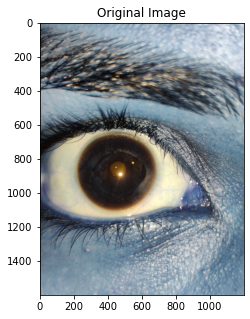

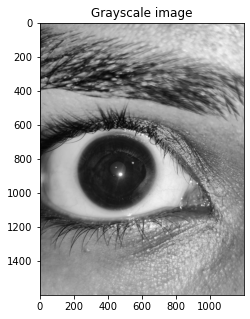

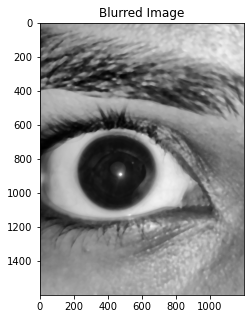

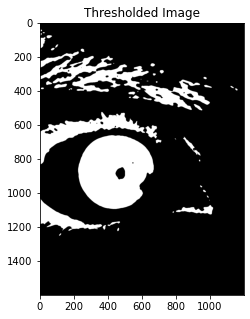

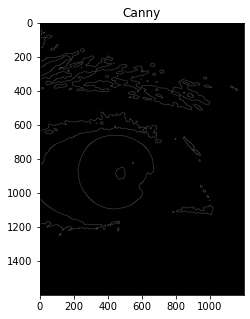

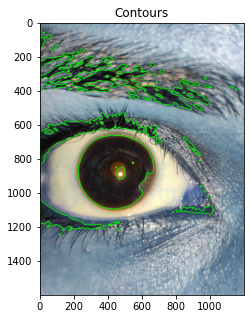

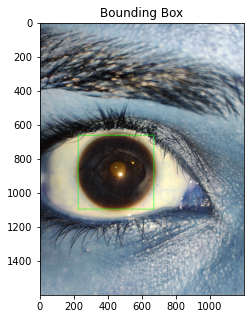

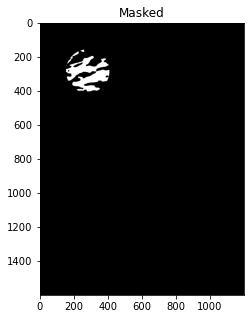

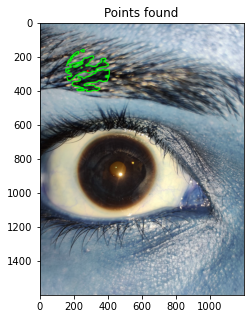

In [105]:
for file in path:
    x = img_processing(file)
    y = calc_radius_in_pixels(x)
    print("Radius calculated by finding average distance between center and pixel border: ",y)
    z = radius_irl(y)
    print("The real life radius of iris is: ",z,"mm")
